# 📊 DETECTOR DE NOTÍCIAS - CAFÉ FUTURO (ICF$)

## 🎯 O que faz?
Analisa dados históricos de café futuro (M5_ICF$.csv) e detecta possíveis datas de notícias através de anomalias de preço/volume.

## 📋 Pré-requisitos
```bash
pip install pandas numpy
```

## 🚀 Como usar

### 1. Prepare seus arquivos
Coloque na mesma pasta:
- `detector_noticias_cafe.py` (o script)
- `M5_ICF$.csv` (seus dados)

### 2. Execute
```bash
python detector_noticias_cafe.py
```

### 3. Resultado
Será gerado: `possiveis_noticias_cafe.csv`

## 📊 Colunas do Arquivo de Saída

| Coluna | Descrição |
|--------|-----------|
| **Time** | Data e hora da anomalia |
| **Ano_Trimestre** | Trimestre (ex: 2024-Q3) |
| **Open/High/Low/Close** | Preços OHLC |
| **Volume** | Volume negociado |
| **Retorno_Pct** | Retorno percentual (%) |
| **Z_Score** | Desvio padrão do retorno |
| **Amplitude_Relativa** | Amplitude vs média |
| **Volume_Relativo** | Volume vs média |
| **Tipo_Movimento** | Alta/Baixa/Neutro |
| **Score_Confianca** | 0-100 (quanto maior, mais provável ser notícia) |

## 🔧 Critérios de Detecção

O script detecta anomalias quando **qualquer um** desses critérios é atendido:

1. **Movimento Forte**: |Z-Score| > 2.5 E |Retorno| > 0.8%
2. **Amplitude Alta**: Amplitude > 2x a média
3. **Volume Anormal**: Volume > 3x a média E |Retorno| > 0.8%

## 🚫 Filtros Aplicados

**Horários IGNORADOS** (volatilidade natural):
- 08:30-09:30 → Abertura NY
- 17:00-18:00 → Fechamento
- Sextas após 15h → Ajuste de fim de semana
- Volume < 3 → Baixa liquidez

## ⚙️ Ajustar Sensibilidade

Edite no início do script:

```python
# Mais anomalias (mais sensível)
ZSCORE_THRESHOLD = 2.0      # era 2.5
RETORNO_MIN = 0.5           # era 0.8

# Menos anomalias (mais restritivo)
ZSCORE_THRESHOLD = 3.0      # era 2.5
RETORNO_MIN = 1.2           # era 0.8
```

## 📚 Workflow Completo

### Passo 1: Execute o script
```bash
python detector_noticias_cafe.py
```

### Passo 2: Abra o CSV no Excel/LibreOffice
- Já vem **ordenado por Score_Confianca** (maiores primeiro)
- Foque nos scores > 70 primeiro

### Passo 3: Pesquise notícias
Para cada data suspeita, pesquise em:
- **Reuters Coffee**: https://www.reuters.com/markets/commodities/
- **ICE Coffee Reports**: https://www.theice.com/products/15/Coffee-C-Futures
- **Notícias Coffee** (BR): https://www.noticiasagricolas.com.br/cotacoes/cafe
- Google News: "café arábica [DATA]"

### Passo 4: Classifique manualmente
Adicione coluna "CLASSIFICACAO" com:
- `NOTICIA_CONFIRMADA` → Encontrou notícia relevante
- `FALSO_POSITIVO` → Sem notícia (movimento técnico)
- `EVENTO_TECNICO` → Liquidação, rollover, etc
- `JA_PRECIFICADA` → Notícia já era esperada

### Passo 5: Treine sua RNA
Use apenas as linhas `NOTICIA_CONFIRMADA` para treinar.

## 🎓 Interpretando os Resultados

### Score de Confiança
- **80-100**: Altíssima probabilidade de notícia
- **60-79**: Alta probabilidade
- **40-59**: Probabilidade moderada
- **0-39**: Probabilidade baixa (pode ser ruído)

### Tipo de Movimento
- **Alta**: Preço subiu > 0.8%
- **Baixa**: Preço caiu > 0.8%
- **Neutro**: Movimento lateral (alta volatilidade, mas sem direção)

## 🐛 Problemas Comuns

### "NENHUMA anomalia detectada"
**Solução**: Reduza os thresholds no script
```python
ZSCORE_THRESHOLD = 2.0  # ao invés de 2.5
RETORNO_MIN = 0.5       # ao invés de 0.8
```

### "Muitas anomalias (>500)"
**Solução**: Aumente os thresholds
```python
ZSCORE_THRESHOLD = 3.0  # ao invés de 2.5
VOLUME_THRESHOLD = 4.0  # ao invés de 3.0
```

### "Erro ao carregar arquivo"
Verifique:
- Nome do arquivo: `M5_ICF$.csv`
- Separador: TAB (não vírgula)
- Primeira linha: `Time	Open	High	Low	Close	Volume`

## 📈 Exemplos de Uso

### Analisar apenas 2024-2025
```python
# Adicione após carregar o CSV:
df = df[df['Time'].dt.year >= 2024]
```

### Exportar apenas scores > 70
```python
# Antes do to_csv:
df_saida = df_saida[df_saida['Score_Confianca'] >= 70]
```

### Separar por trimestre
```python
# Após gerar df_saida:
for trim in df_saida['Ano_Trimestre'].unique():
    df_trim = df_saida[df_saida['Ano_Trimestre'] == trim]
    df_trim.to_csv(f'anomalias_{trim}.csv', sep=';', index=False)
```

## 🤝 Dicas para Classificação Manual

1. **Contexto importa**: Uma alta de 1% pode ser "nada" em Q3 (safra) mas "muito" em Q1
2. **Olhe ±2h**: Notícia pode demorar para refletir no preço
3. **Considere o mercado global**: Dólar forte, clima nos EUA, etc
4. **Falsas alarmes comuns**:
   - Primeira/última hora do pregão
   - Dias de vencimento de contrato
   - Feriados parciais (baixa liquidez)

## 📞 Suporte

Se precisar ajustar algo ou tiver dúvidas, me avise!

---
**Criado por**: Claude AI  
**Versão**: 1.0  
**Data**: Janeiro 2026

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Detector de Possíveis Notícias em Café Futuro (ICF$) - VERSÃO 2.0
Análise por Trimestre com Z-Score Adaptativo
Exige múltiplos critérios para reduzir falsos positivos
"""

import pandas as pd
import numpy as np
from datetime import time
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURAÇÕES ====================
INPUT_FILE = 'M5_ICF$.csv'
OUTPUT_FILE = 'possiveis_noticias_cafe_v2.csv'

# Critérios de Anomalia (ajustáveis)
ZSCORE_THRESHOLD = 2.5          # Desvio padrão do retorno
AMPLITUDE_THRESHOLD = 6.0       # Multiplicador da amplitude média
VOLUME_THRESHOLD = 5.0          # Multiplicador do volume médio
MIN_CRITERIOS = 2               # Mínimo de critérios para ser anomalia

# Parâmetros do Z-Score Adaptativo
LIMITE_MAX = 1.0                # Limite quando Z-score = 0 (%)
LIMITE_MIN = 0.4                # Limite mínimo absoluto (%)
TAXA_DECAIMENTO = 5.0           # Divisor do Z-score (quanto maior, mais conservador)

# Janelas para cálculos
ROLLING_WINDOW = 100            # ~8 horas de pregão (100 barras de 5min)
VOLUME_WINDOW = 20              # Janela para média de volume

# Horários a IGNORAR (abertura/fechamento com alta volatilidade natural)
HORARIOS_IGNORAR = [
    (time(8, 30), time(9, 30)),   # Abertura NY
    (time(17, 0), time(18, 0)),   # Fechamento
]

# ==================== FUNÇÕES AUXILIARES ====================

def calcular_metricas(df):
    """Calcula todas as métricas para detecção de anomalias"""
    
    # 1. Retorno percentual
    df['Retorno_Pct'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    
    # 2. Amplitude relativa
    df['Amplitude'] = (df['High'] - df['Low']) / df['Close']
    
    # 3. Z-score com rolling window
    df['Retorno_Media'] = df['Retorno_Pct'].rolling(window=ROLLING_WINDOW, min_periods=20).mean()
    df['Retorno_Std'] = df['Retorno_Pct'].rolling(window=ROLLING_WINDOW, min_periods=20).std()
    df['Z_Score'] = (df['Retorno_Pct'] - df['Retorno_Media']) / df['Retorno_Std']
    
    # 4. Amplitude relativa normalizada (vs média móvel)
    df['Amplitude_Media'] = df['Amplitude'].rolling(window=ROLLING_WINDOW, min_periods=20).mean()
    df['Amplitude_Relativa'] = df['Amplitude'] / df['Amplitude_Media']
    
    # 5. Volume relativo
    df['Volume_Media'] = df['Volume'].rolling(window=VOLUME_WINDOW, min_periods=5).mean()
    df['Volume_Relativo'] = df['Volume'] / df['Volume_Media']
    
    # 6. Volatilidade intrabar
    df['Volatilidade_Intra'] = (df['High'] - df['Low']) / df['Open']
    
    return df

def filtrar_horarios_ruins(df):
    """Remove horários com volatilidade natural alta"""
    
    mask_valido = pd.Series([True] * len(df), index=df.index)
    
    for inicio, fim in HORARIOS_IGNORAR:
        mask_horario = (df['Hora'] >= inicio) & (df['Hora'] <= fim)
        mask_valido = mask_valido & ~mask_horario
    
    # Ignorar sextas após 15h
    mask_sexta = (df['DiaSemana'] == 4) & (df['Hora'] >= time(15, 0))
    mask_valido = mask_valido & ~mask_sexta
    
    # Ignorar barras com volume muito baixo (<3)
    mask_volume = df['Volume'] >= 3
    mask_valido = mask_valido & mask_volume
    
    return df[mask_valido]

def calcular_limite_dinamico(z_score):
    """
    Calcula limite dinâmico baseado em Z-score
    
    Fórmula: L(z) = max(LIMITE_MIN, LIMITE_MAX - |z| / TAXA_DECAIMENTO)
    
    Quanto maior o Z-score (mais anormal), menor o retorno necessário
    """
    return max(LIMITE_MIN, LIMITE_MAX - (abs(z_score) / TAXA_DECAIMENTO))

def classificar_movimento_adaptativo(row):
    """
    Classifica movimento usando Z-score adaptativo
    
    Lógica:
    - Calcula limite dinâmico baseado no Z-score
    - Se retorno > limite → Alta/Baixa
    - Se retorno < limite → Neutro
    """
    retorno = row['Retorno_Pct']
    z_score = row['Z_Score']
    
    # Evita NaN
    if pd.isna(z_score) or pd.isna(retorno):
        return 'Neutro', 0.0
    
    # Calcula limite dinâmico
    limite = calcular_limite_dinamico(z_score)
    
    # Classifica
    if abs(retorno) > limite:
        tipo = 'Alta' if retorno > 0 else 'Baixa'
    else:
        tipo = 'Neutro'
    
    return tipo, limite

def detectar_anomalias(df):
    """
    Detecta anomalias exigindo múltiplos critérios
    """
    
    # Critérios individuais (mesmo de antes)
    criterio1 = (np.abs(df['Z_Score']) > ZSCORE_THRESHOLD) & (np.abs(df['Retorno_Pct']) > 0.3)
    criterio2 = df['Amplitude_Relativa'] > AMPLITUDE_THRESHOLD
    criterio3 = (df['Volume_Relativo'] > VOLUME_THRESHOLD) & (np.abs(df['Retorno_Pct']) > 0.3)
    
    # Conta quantos critérios foram atendidos
    df['Num_Criterios'] = (
        criterio1.astype(int) + 
        criterio2.astype(int) + 
        criterio3.astype(int)
    )
    
    # NOVO: Só é anomalia se atender pelo menos MIN_CRITERIOS
    df['Anomalia'] = df['Num_Criterios'] >= MIN_CRITERIOS
    
    # Identifica qual critério foi mais forte (para visualização)
    df['Criterio_Principal'] = 'Nenhum'
    df.loc[criterio1 & df['Anomalia'], 'Criterio_Principal'] = 'Z-Score Alto'
    df.loc[criterio2 & df['Anomalia'] & (df['Amplitude_Relativa'] > df['Volume_Relativo']), 'Criterio_Principal'] = 'Amplitude Alta'
    df.loc[criterio3 & df['Anomalia'], 'Criterio_Principal'] = 'Volume Alto'
    
    # NOVO: Classifica movimento com Z-score adaptativo
    df[['Tipo_Movimento', 'Limite_Dinamico']] = df.apply(
        lambda row: pd.Series(classificar_movimento_adaptativo(row)), 
        axis=1
    )
    
    # Score de confiança (0-100)
    df['Score_Confianca'] = 0.0
    df.loc[df['Anomalia'], 'Score_Confianca'] = (
        (np.abs(df['Z_Score']) / 5.0 * 40) +  # Max 40 pontos
        (df['Amplitude_Relativa'] / 4.0 * 30) +  # Max 30 pontos
        (df['Volume_Relativo'] / 5.0 * 30)  # Max 30 pontos
    )
    df['Score_Confianca'] = df['Score_Confianca'].clip(0, 100)
    
    return df[df['Anomalia']].copy()

def adicionar_trimestre(df):
    """Adiciona coluna de trimestre"""
    df['Trimestre'] = df['Time'].dt.quarter
    df['Ano_Trimestre'] = df['Time'].dt.year.astype(str) + '-Q' + df['Trimestre'].astype(str)
    return df

# ==================== PROCESSAMENTO PRINCIPAL ====================

print("\n📂 Carregando arquivo:", INPUT_FILE)
try:
    # Lê CSV com separador TAB
    df = pd.read_csv(INPUT_FILE, sep='\t', parse_dates=['Time'])
    print(f"✅ Carregado: {len(df):,} registros")
    print(f"📅 Período: {df['Time'].min()} até {df['Time'].max()}")
except Exception as e:
    print(f"❌ ERRO ao carregar arquivo: {e}")
    print("\n💡 Verifique se:")
    print("   - O arquivo 'M5_ICF$.csv' está na mesma pasta")
    print("   - O separador é TAB (\\t)")
    print("   - A primeira coluna se chama 'Time'")
    exit(1)

# Extrai informações temporais
df['Hora'] = df['Time'].dt.time
df['DiaSemana'] = df['Time'].dt.dayofweek  # 0=Segunda, 4=Sexta
df = adicionar_trimestre(df)

print(f"\n🗓️  Trimestres encontrados: {df['Ano_Trimestre'].nunique()}")
print(df['Ano_Trimestre'].value_counts().sort_index())

# Calcula métricas
print("\n⚙️  Calculando métricas estatísticas...")
df = calcular_metricas(df)

# Filtra horários ruins
print(f"🔧 Filtrando horários de abertura/fechamento...")
total_antes = len(df)
df = filtrar_horarios_ruins(df)
print(f"   Removidos: {total_antes - len(df):,} registros ({(total_antes - len(df))/total_antes*100:.1f}%)")

# Detecta anomalias por trimestre
print(f"\n🎯 Detectando anomalias por trimestre (mín. {MIN_CRITERIOS} critérios)...")
anomalias_list = []

for trimestre in sorted(df['Ano_Trimestre'].unique()):
    df_trim = df[df['Ano_Trimestre'] == trimestre].copy()
    anomalias_trim = detectar_anomalias(df_trim)
    
    if len(anomalias_trim) > 0:
        anomalias_trim['Ano_Trimestre'] = trimestre
        anomalias_list.append(anomalias_trim)
        print(f"   {trimestre}: {len(anomalias_trim)} anomalias detectadas")

# Combina todas as anomalias
if len(anomalias_list) == 0:
    print("\n⚠️  NENHUMA anomalia detectada!")
    print("💡 Sugestões:")
    print(f"   - Reduza MIN_CRITERIOS (atual: {MIN_CRITERIOS} → tente 1)")
    print(f"   - Reduza ZSCORE_THRESHOLD (atual: {ZSCORE_THRESHOLD} → tente 2.0)")
    print(f"   - Aumente LIMITE_MAX (atual: {LIMITE_MAX} → tente 1.2)")
    exit(0)

df_anomalias = pd.concat(anomalias_list, ignore_index=True)

# Ordena por score de confiança (maior primeiro)
df_anomalias = df_anomalias.sort_values('Score_Confianca', ascending=False)

print(f"\n✨ Total de anomalias detectadas: {len(df_anomalias)}")

# ==================== ESTATÍSTICAS PRÉ-EXPORTAÇÃO ====================

print("\n" + "="*70)
print("📊 ANÁLISE DAS ANOMALIAS DETECTADAS")
print("="*70)

print(f"\n🔢 Distribuição por Número de Critérios:")
print(df_anomalias['Num_Criterios'].value_counts().sort_index())

print(f"\n🎯 Distribuição por Tipo de Movimento:")
print(df_anomalias['Tipo_Movimento'].value_counts())

neutros = len(df_anomalias[df_anomalias['Tipo_Movimento'] == 'Neutro'])
total = len(df_anomalias)
print(f"\n⚠️  Neutros: {neutros} de {total} ({neutros/total*100:.1f}%)")

print(f"\n🎨 Critério Principal:")
print(df_anomalias['Criterio_Principal'].value_counts())

# ==================== EXPORTAÇÃO ====================

# Seleciona colunas relevantes para saída
colunas_saida = [
    'Time', 'Ano_Trimestre', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Retorno_Pct', 'Z_Score', 'Amplitude_Relativa', 'Volume_Relativo',
    'Tipo_Movimento', 'Limite_Dinamico', 'Num_Criterios', 'Criterio_Principal', 'Score_Confianca'
]

df_saida = df_anomalias[colunas_saida].copy()

# Formata valores numéricos
df_saida['Retorno_Pct'] = df_saida['Retorno_Pct'].round(2)
df_saida['Z_Score'] = df_saida['Z_Score'].round(2)
df_saida['Amplitude_Relativa'] = df_saida['Amplitude_Relativa'].round(2)
df_saida['Volume_Relativo'] = df_saida['Volume_Relativo'].round(1)
df_saida['Limite_Dinamico'] = df_saida['Limite_Dinamico'].round(2)
df_saida['Score_Confianca'] = df_saida['Score_Confianca'].round(0).astype(int)

# Exporta com separador ;
df_saida.to_csv(OUTPUT_FILE, sep=';', index=False, date_format='%Y-%m-%d %H:%M:%S')

print(f"\n💾 Arquivo salvo: {OUTPUT_FILE}")
print(f"   Formato: CSV com separador ';'")
print(f"   Total de linhas: {len(df_saida)}")

# ==================== ESTATÍSTICAS FINAIS ====================

print("\n" + "="*70)
print("📊 TOP 10 ANOMALIAS (MAIOR SCORE)")
print("="*70)

top10 = df_saida.head(10)[['Time', 'Retorno_Pct', 'Z_Score', 'Tipo_Movimento', 'Num_Criterios', 'Score_Confianca']]
print(top10.to_string(index=False))

print(f"\n📅 Distribuição por Trimestre:")
print(df_saida['Ano_Trimestre'].value_counts().sort_index())

print(f"\n💡 Informações sobre Z-Score Adaptativo:")
print(f"   - Limite máximo: {LIMITE_MAX}% (quando Z-score = 0)")
print(f"   - Limite mínimo: {LIMITE_MIN}% (quando Z-score ≥ {TAXA_DECAIMENTO})")
print(f"   - Taxa de decaimento: 1/{TAXA_DECAIMENTO} = {1/TAXA_DECAIMENTO:.2f} por unidade de Z-score")
print(f"\n   Exemplos de limites dinâmicos:")
for z in [0, 1, 2, 2.5, 3, 4, 5]:
    limite = calcular_limite_dinamico(z)
    print(f"      Z-score = {z:.1f} → Limite = {limite:.2f}%")

print(f"\n💡 Próximos passos:")
print(f"   1. Abra o arquivo '{OUTPUT_FILE}' no Excel/LibreOffice")
print(f"   2. Foque em anomalias com:")
print(f"      - Score_Confianca > 70")
print(f"      - Num_Criterios = 3 (atendeu todos os critérios)")
print(f"      - Tipo_Movimento = 'Alta' ou 'Baixa' (evite Neutros)")
print(f"   3. Para cada data, pesquise notícias em:")
print(f"      - Reuters Coffee")
print(f"      - ICE Coffee Reports")
print(f"      - Notícias Coffee (BR)")
print(f"   4. Classifique manualmente e treine sua RNA")

print("\n" + "="*70)
print("✅ PROCESSAMENTO CONCLUÍDO!")
print("="*70)


📂 Carregando arquivo: M5_ICF$.csv
✅ Carregado: 70,587 registros
📅 Período: 2021-01-04 09:00:00 até 2026-01-02 15:55:00

🗓️  Trimestres encontrados: 21
Ano_Trimestre
2021-Q1    2553
2021-Q2    2963
2021-Q3    3579
2021-Q4    3954
2022-Q1    3754
2022-Q2    3836
2022-Q3    4029
2022-Q4    3619
2023-Q1    3369
2023-Q2    3205
2023-Q3    3170
2023-Q4    3455
2024-Q1    3306
2024-Q2    3872
2024-Q3    3932
2024-Q4    3563
2025-Q1    3435
2025-Q2    3449
2025-Q3    3856
2025-Q4    3631
2026-Q1      57
Name: count, dtype: int64

⚙️  Calculando métricas estatísticas...
🔧 Filtrando horários de abertura/fechamento...
   Removidos: 33,487 registros (47.4%)

🎯 Detectando anomalias por trimestre (mín. 2 critérios)...
   2021-Q1: 43 anomalias detectadas
   2021-Q2: 35 anomalias detectadas
   2021-Q3: 24 anomalias detectadas
   2021-Q4: 25 anomalias detectadas
   2022-Q1: 20 anomalias detectadas
   2022-Q2: 21 anomalias detectadas
   2022-Q3: 18 anomalias detectadas
   2022-Q4: 23 anomalias detectad

📊 VISUALIZADOR DE ANOMALIAS - POR SEMESTRE

📂 Carregando dados...
✅ Preços: 70,587 registros
✅ Anomalias: 536 registros
✅ Anomalias filtradas (score >= 50): 536

📅 Anos encontrados: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025), np.int32(2026)]
🎨 Gerando gráficos por semestre...
   (Cada ano terá 2 gráficos: S1 e S2)

📊 Processando ano 2021...
   📈 S1 (Jan-Jun): 78 anomalias
   💾 Salvo: anomalias_2021_S1.png


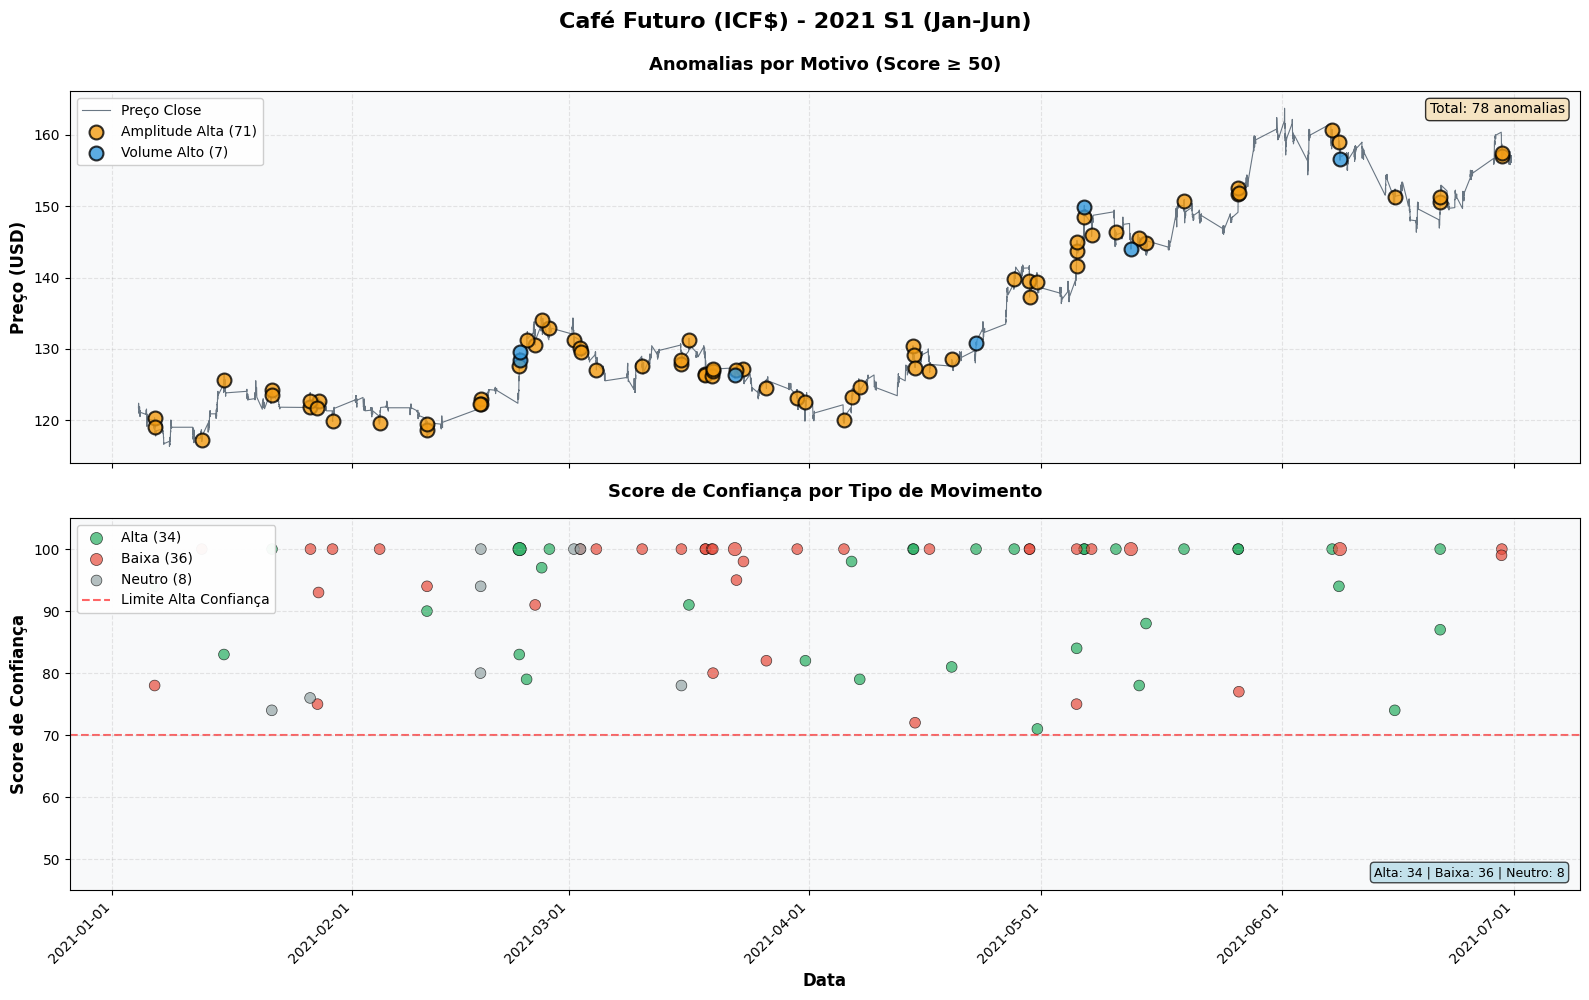

   📈 S2 (Jul-Dez): 49 anomalias
   💾 Salvo: anomalias_2021_S2.png


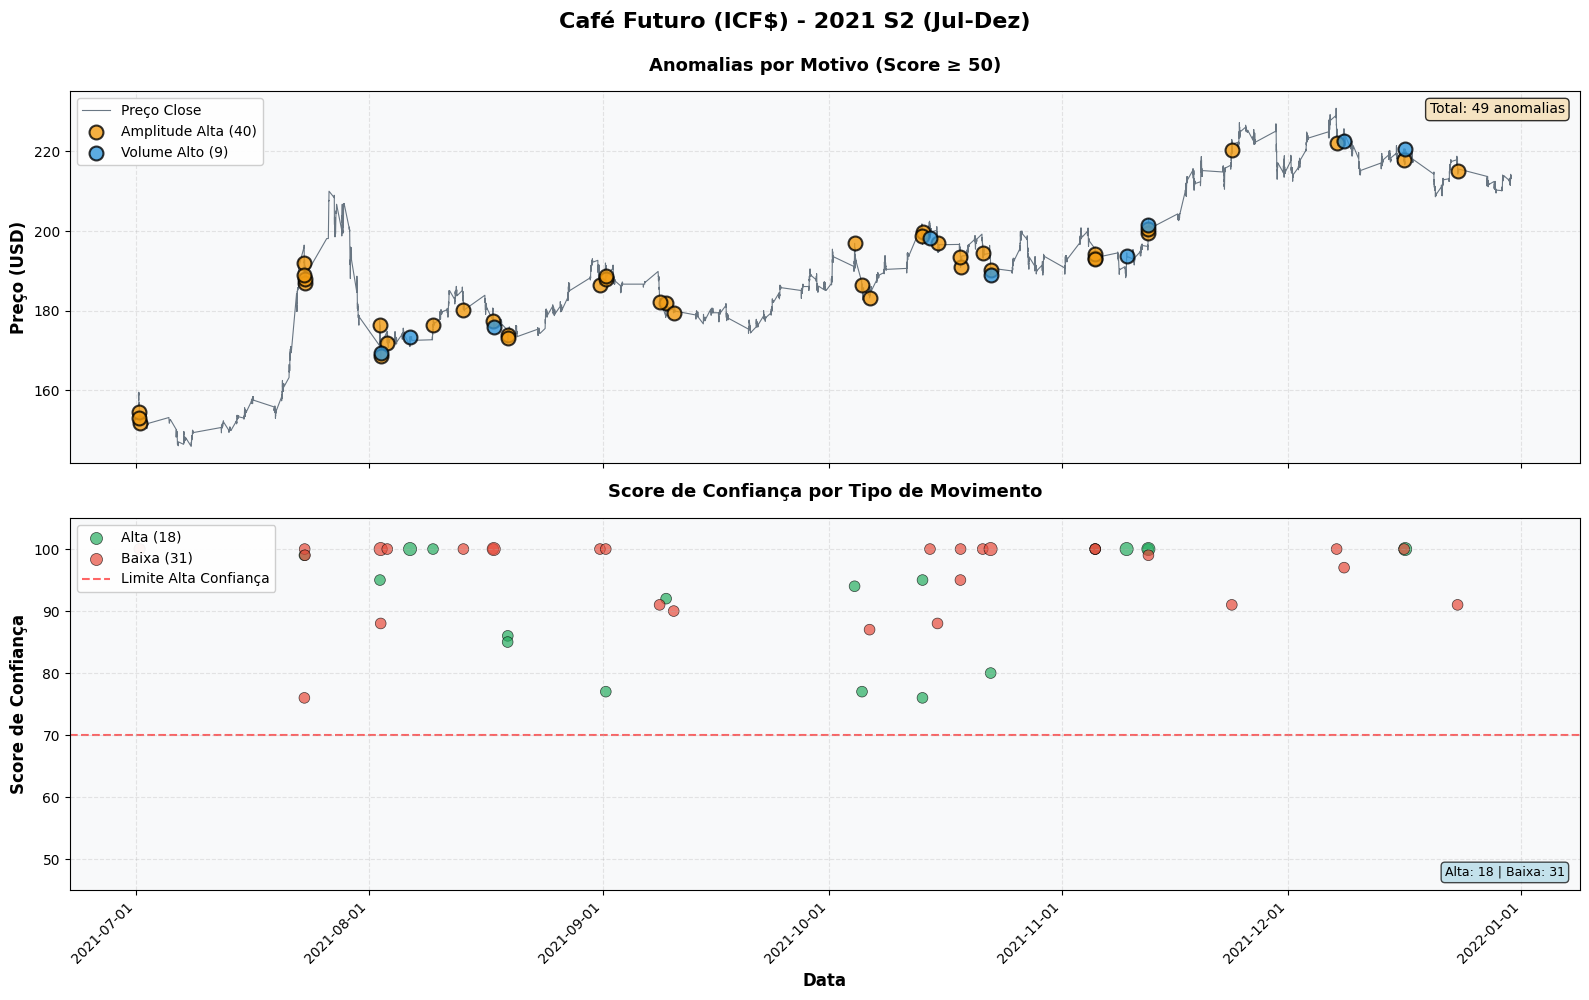


📊 Processando ano 2022...
   📈 S1 (Jan-Jun): 41 anomalias
   💾 Salvo: anomalias_2022_S1.png


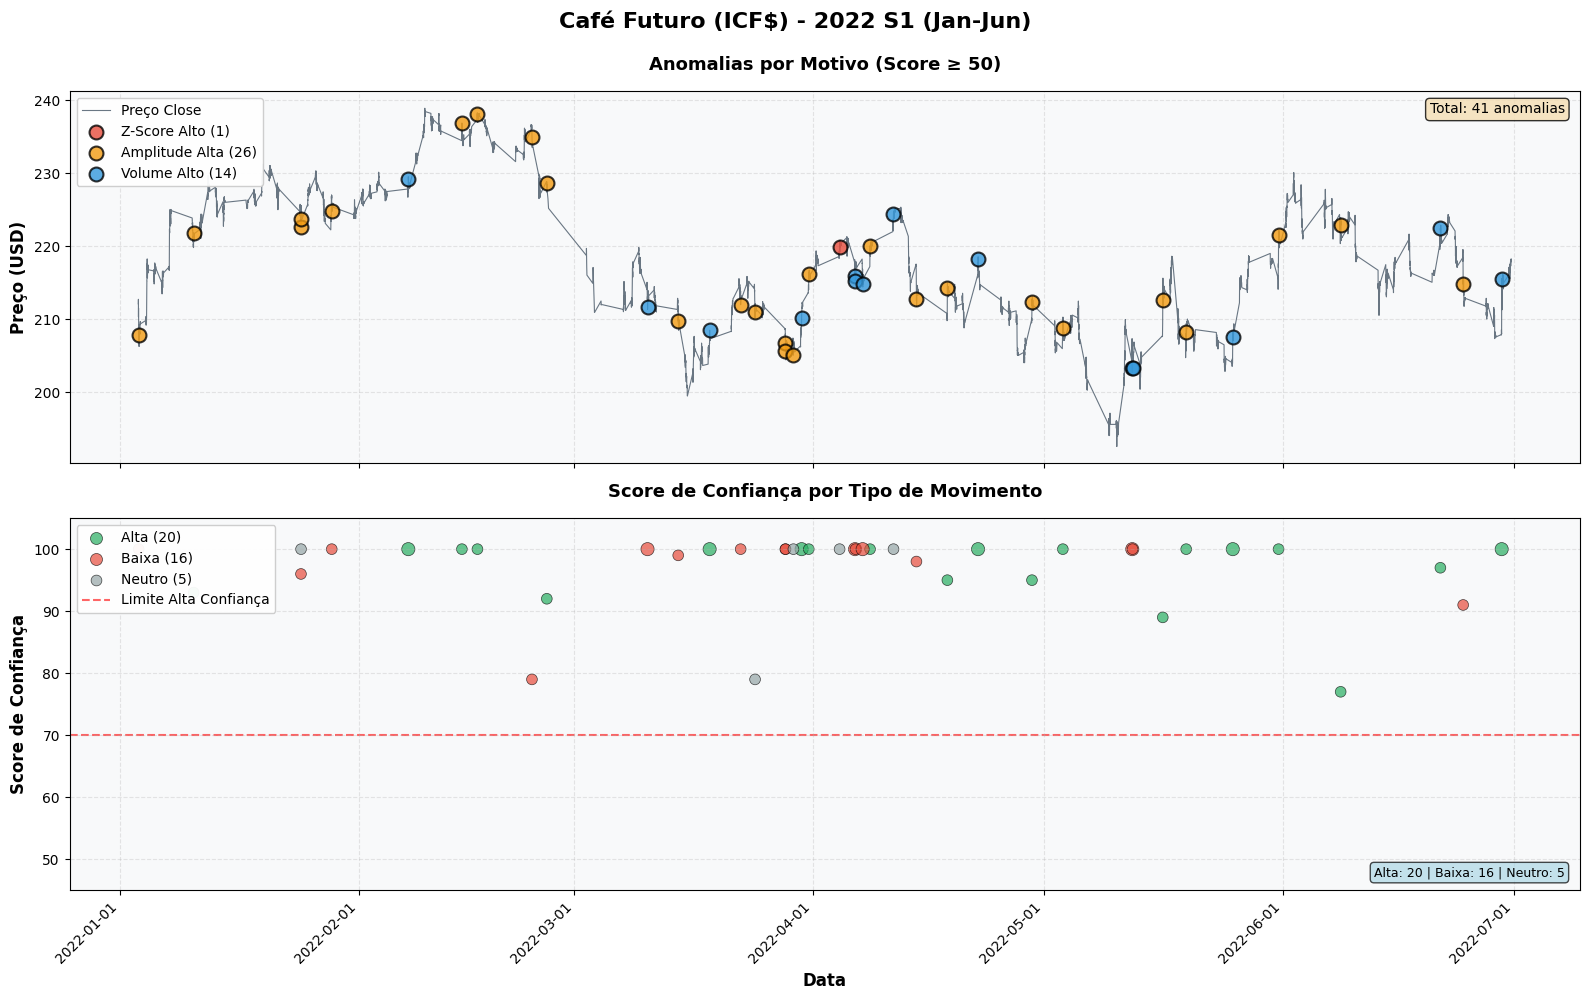

   📈 S2 (Jul-Dez): 41 anomalias
   💾 Salvo: anomalias_2022_S2.png


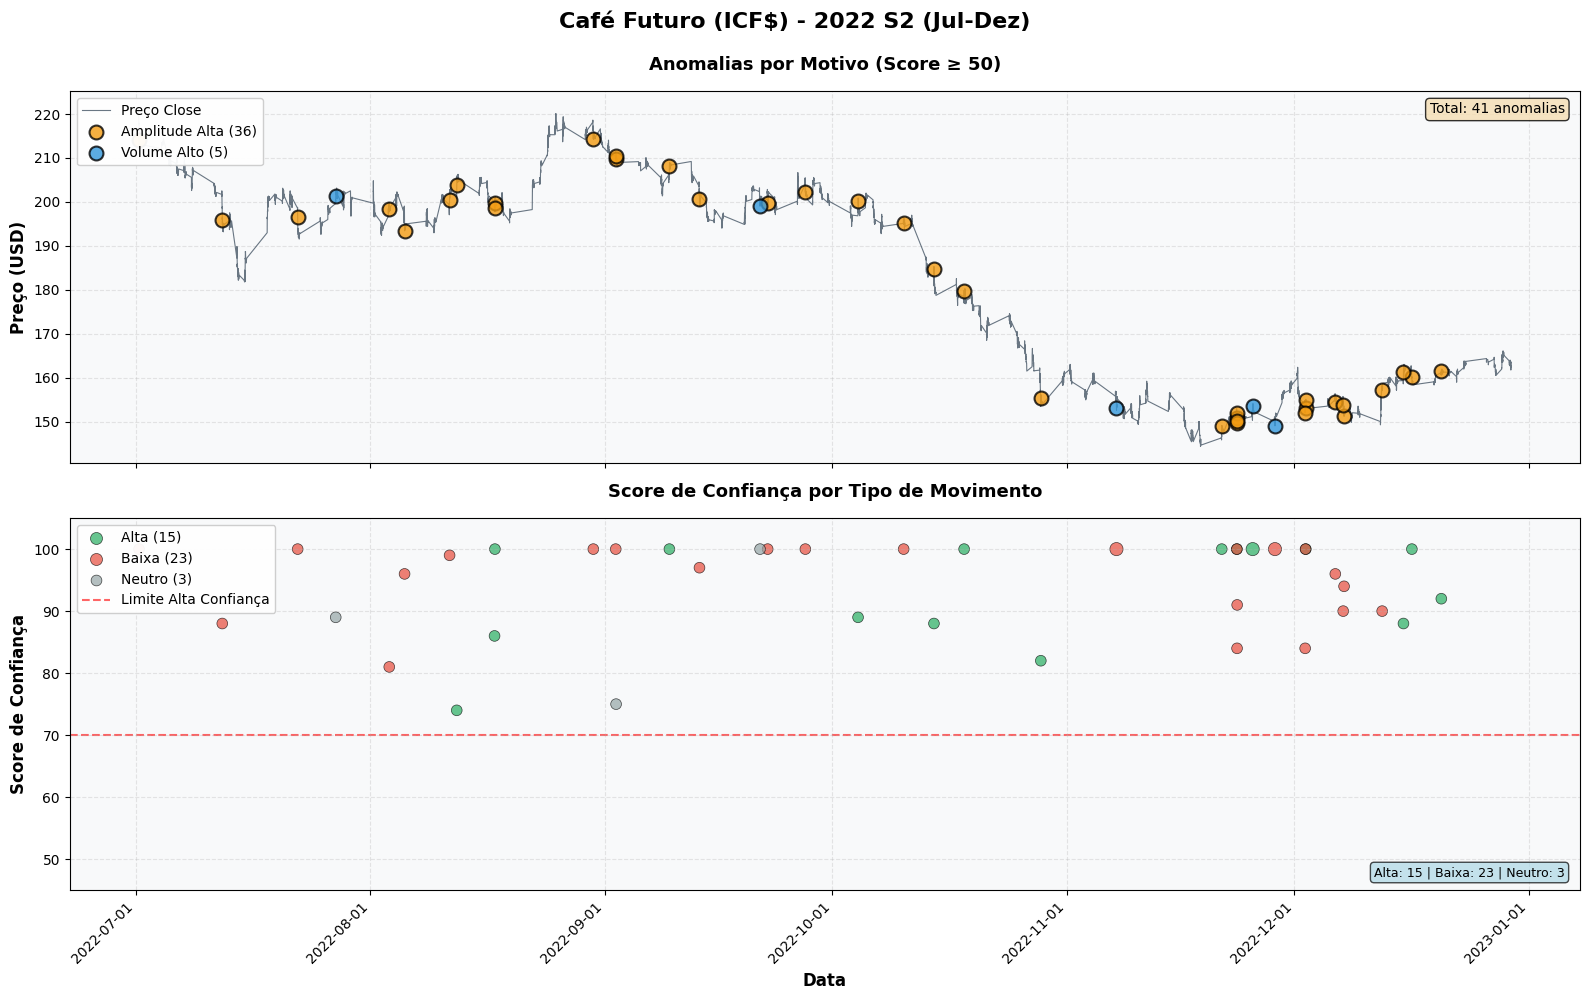


📊 Processando ano 2023...
   📈 S1 (Jan-Jun): 44 anomalias
   💾 Salvo: anomalias_2023_S1.png


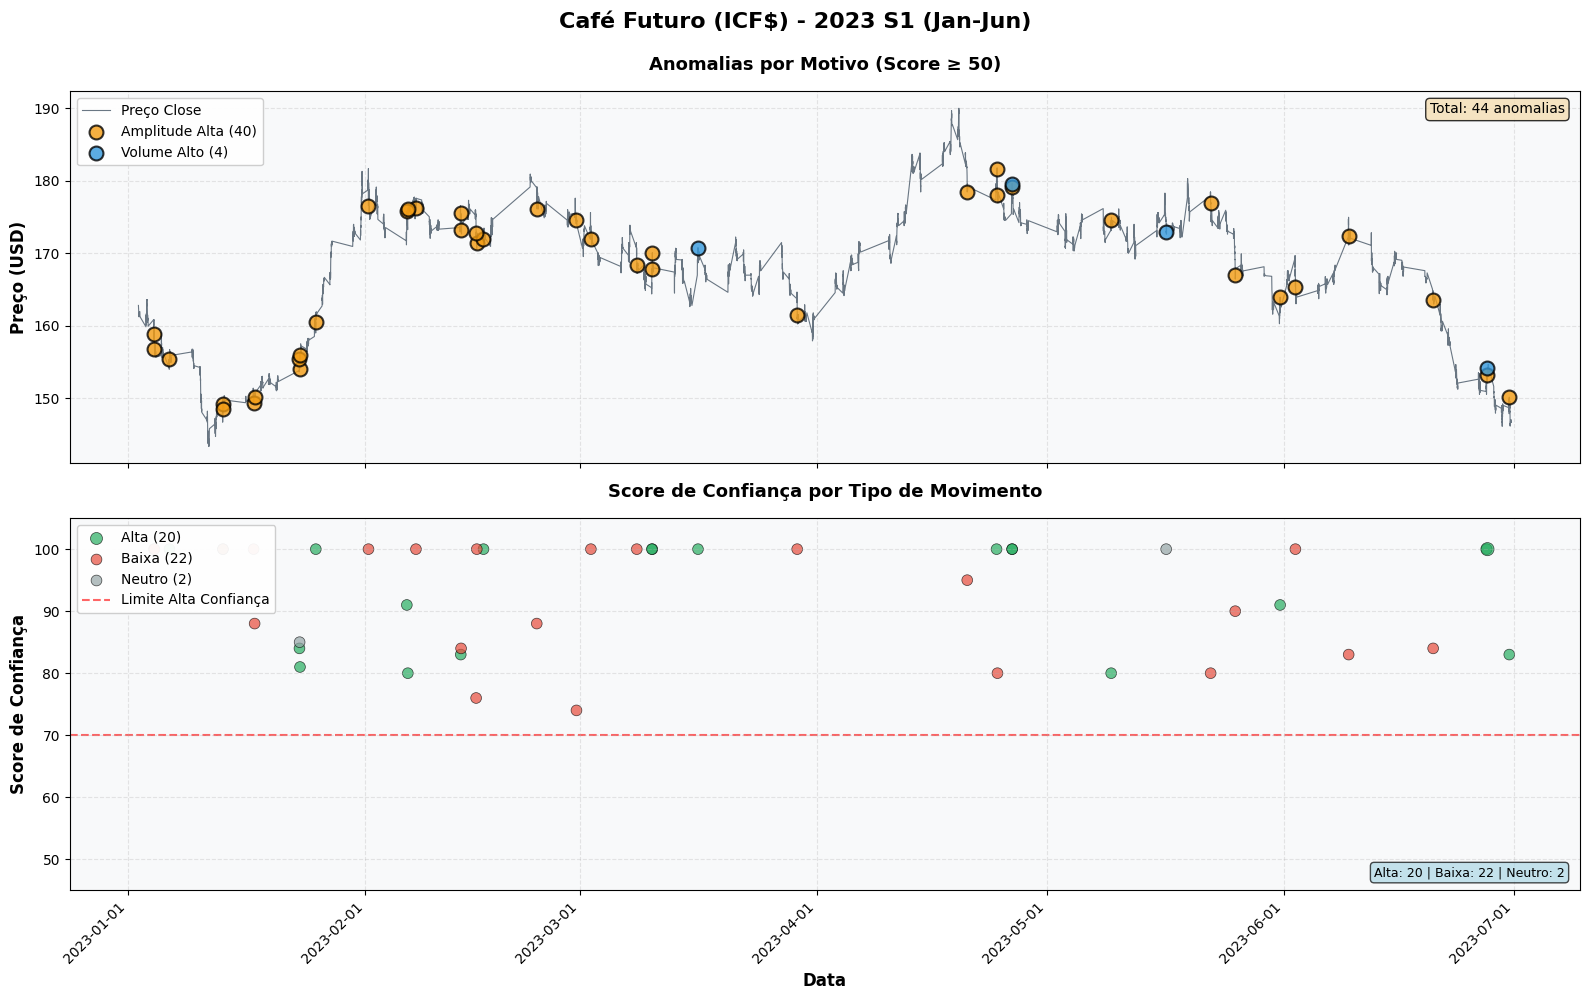

   📈 S2 (Jul-Dez): 62 anomalias
   💾 Salvo: anomalias_2023_S2.png


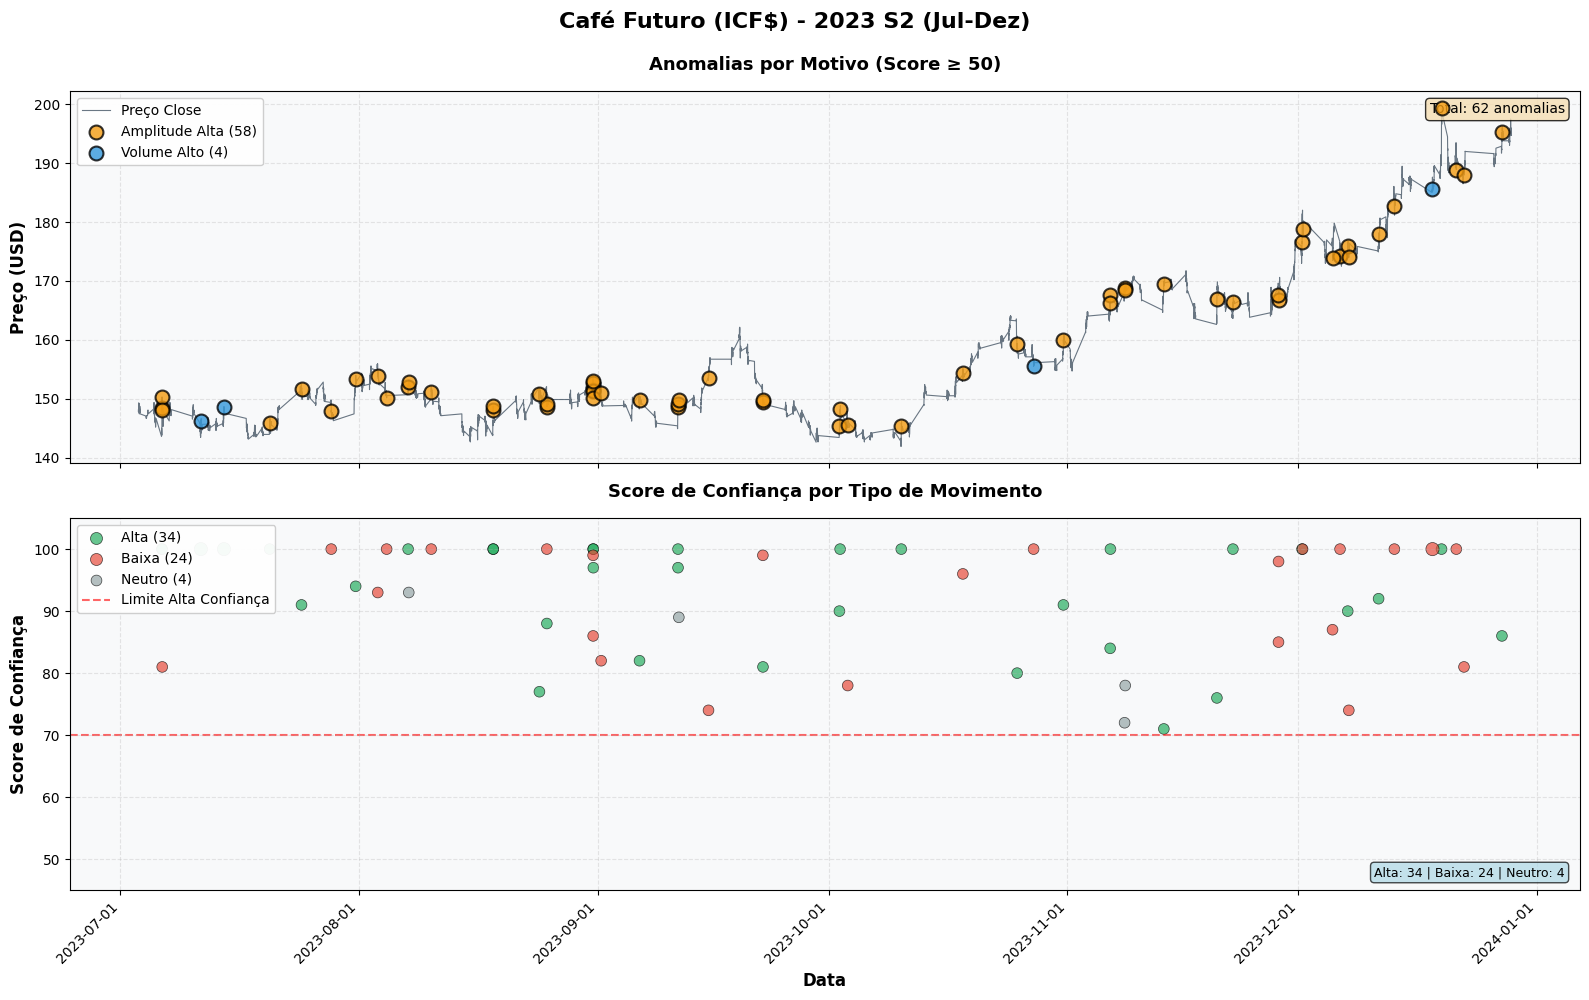


📊 Processando ano 2024...
   📈 S1 (Jan-Jun): 55 anomalias
   💾 Salvo: anomalias_2024_S1.png


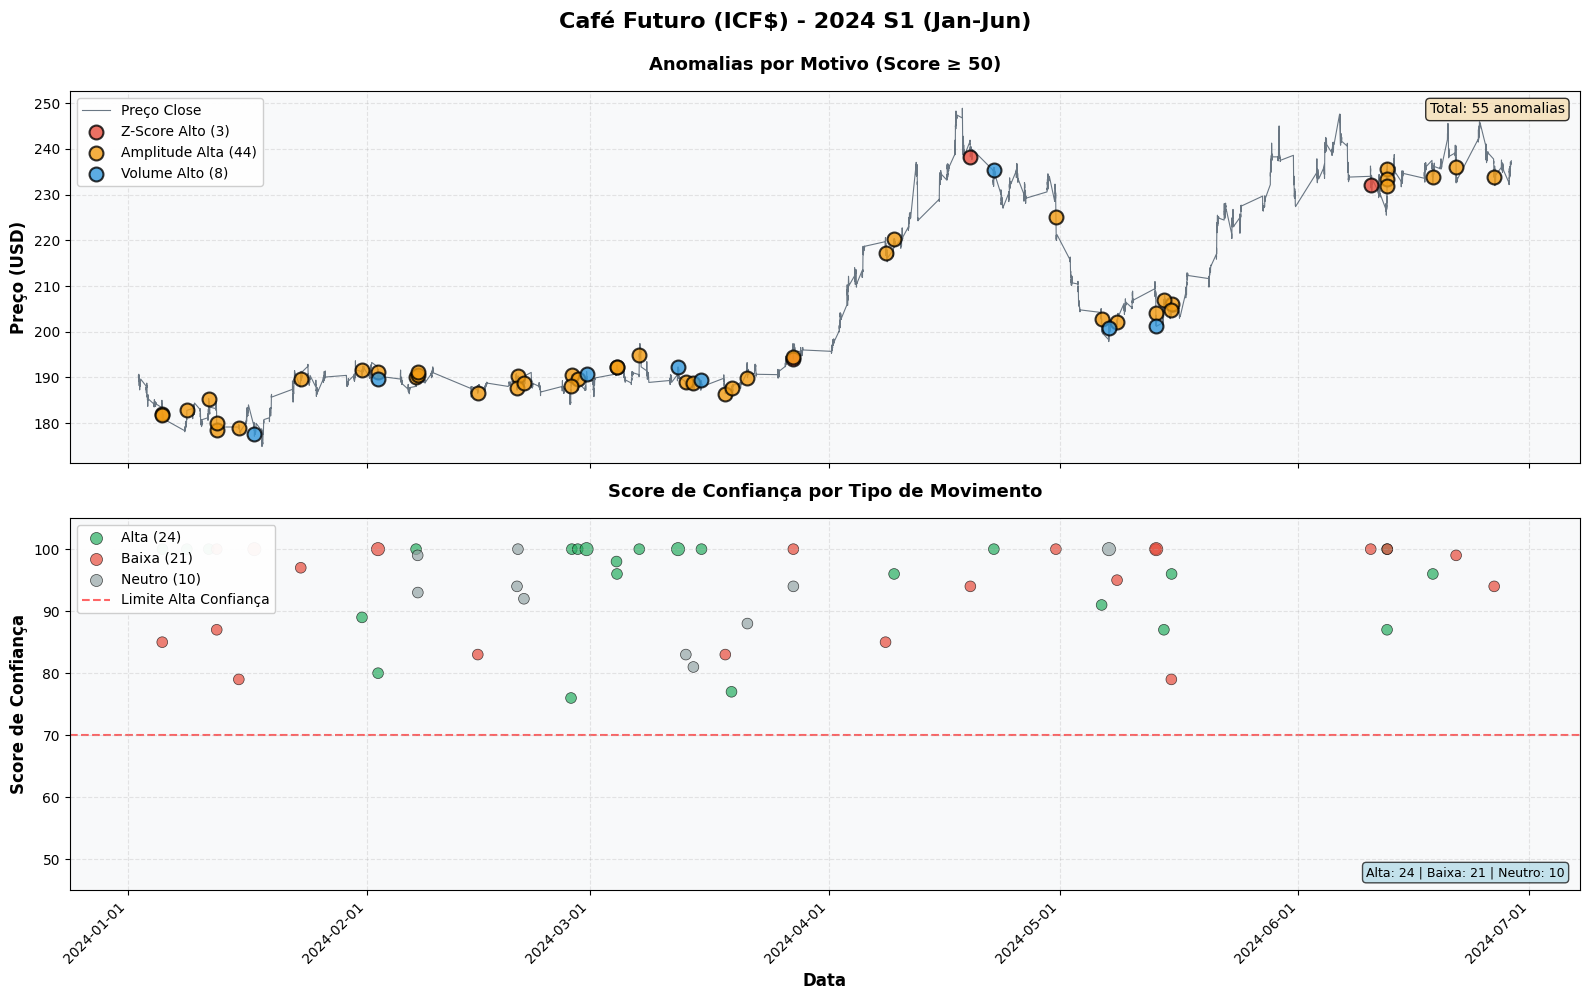

   📈 S2 (Jul-Dez): 55 anomalias
   💾 Salvo: anomalias_2024_S2.png


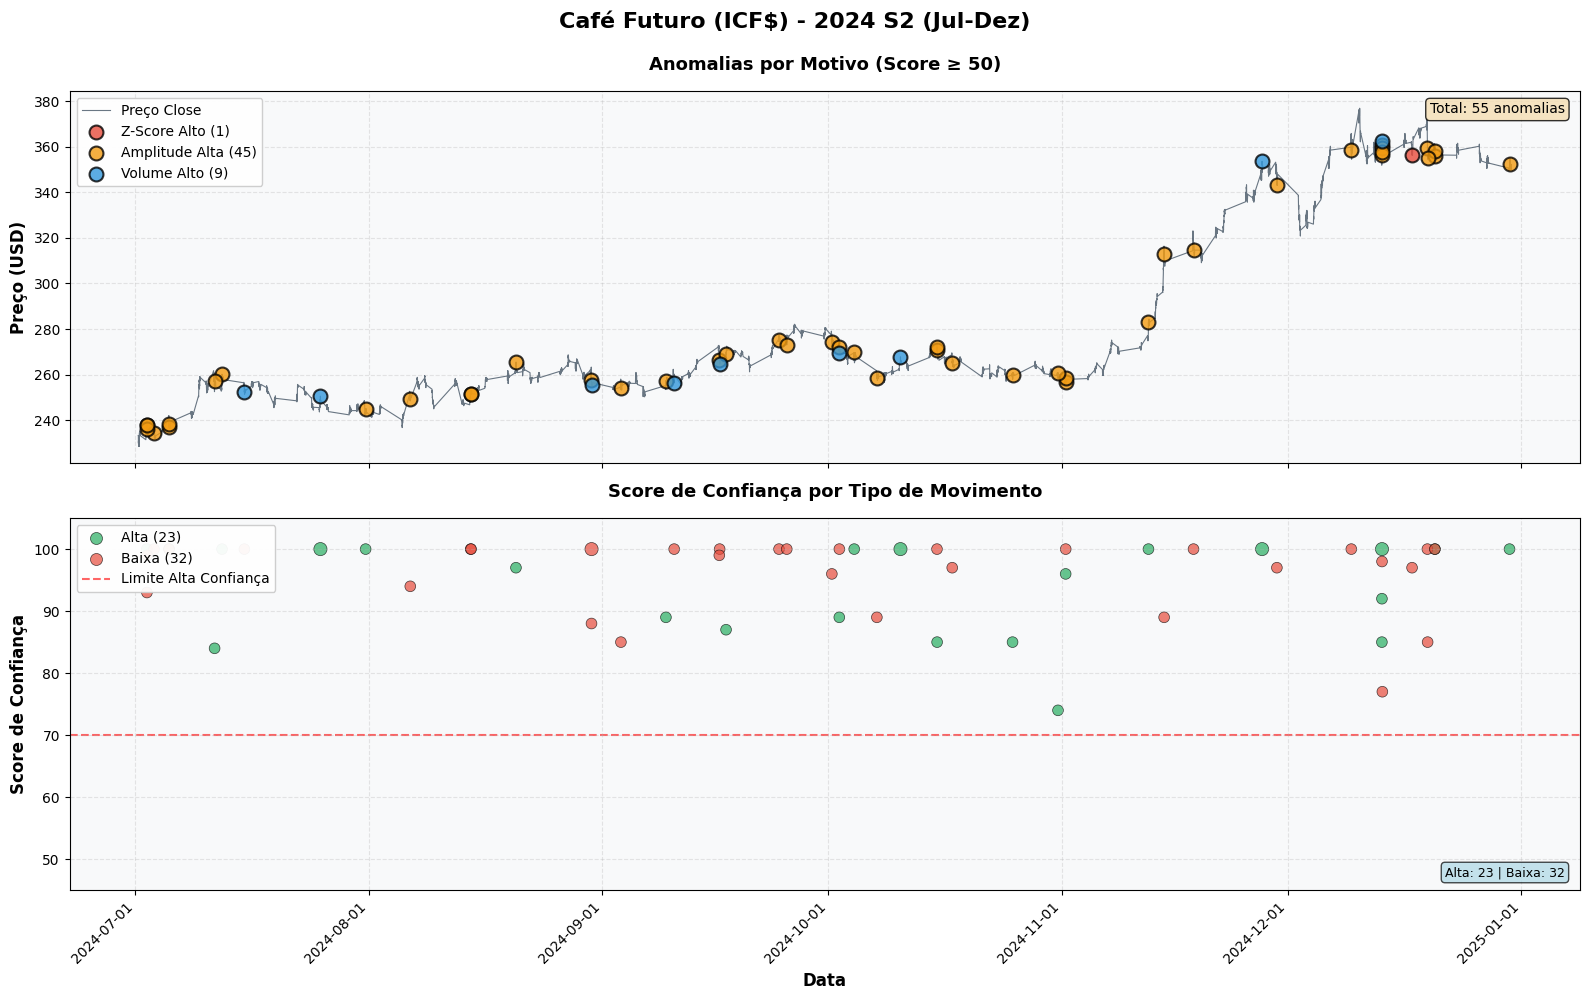


📊 Processando ano 2025...
   📈 S1 (Jan-Jun): 66 anomalias
   💾 Salvo: anomalias_2025_S1.png


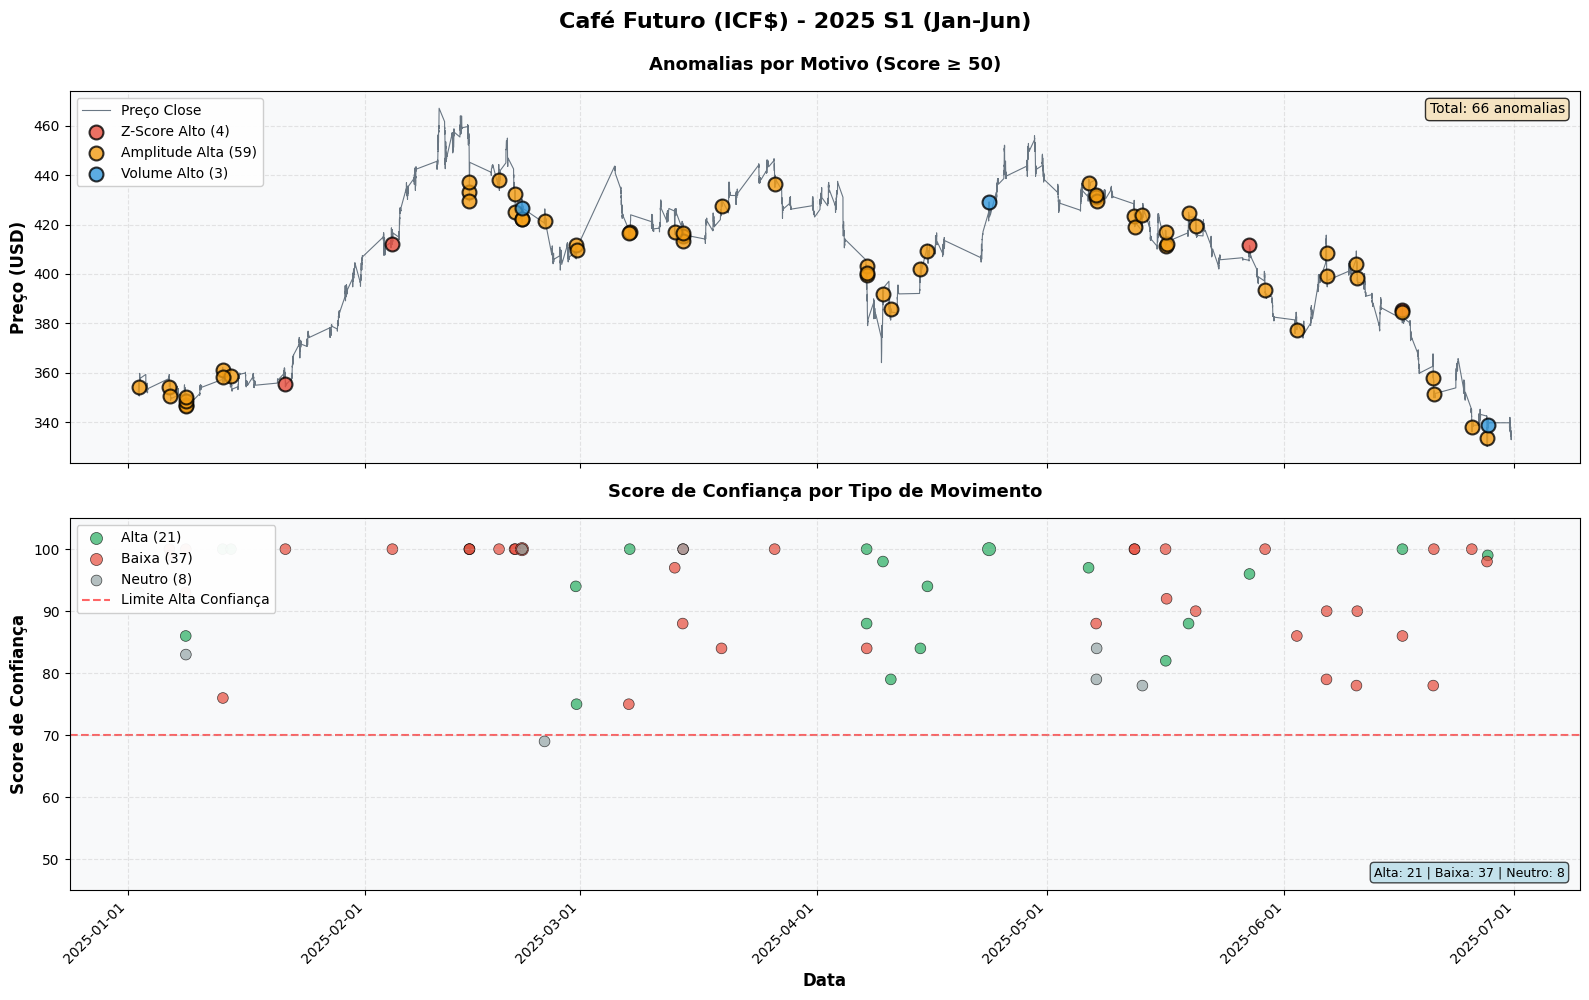

   📈 S2 (Jul-Dez): 45 anomalias
   💾 Salvo: anomalias_2025_S2.png


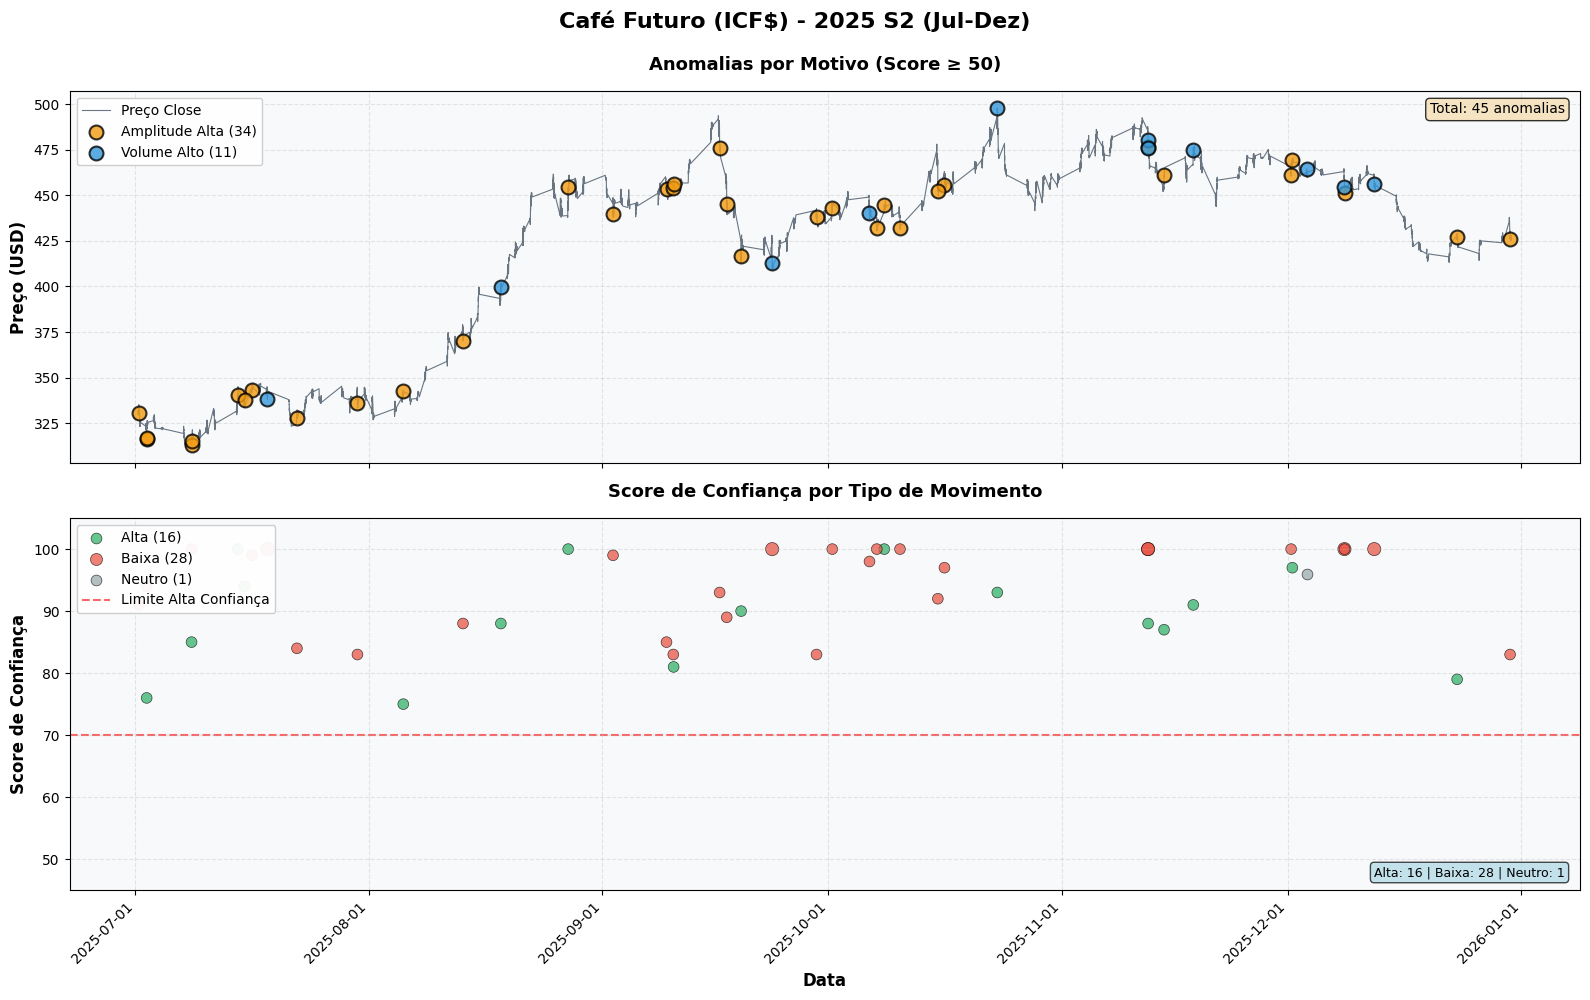


📊 Processando ano 2026...
   📈 S1 (Jan-Jun): 0 anomalias
   💾 Salvo: anomalias_2026_S1.png


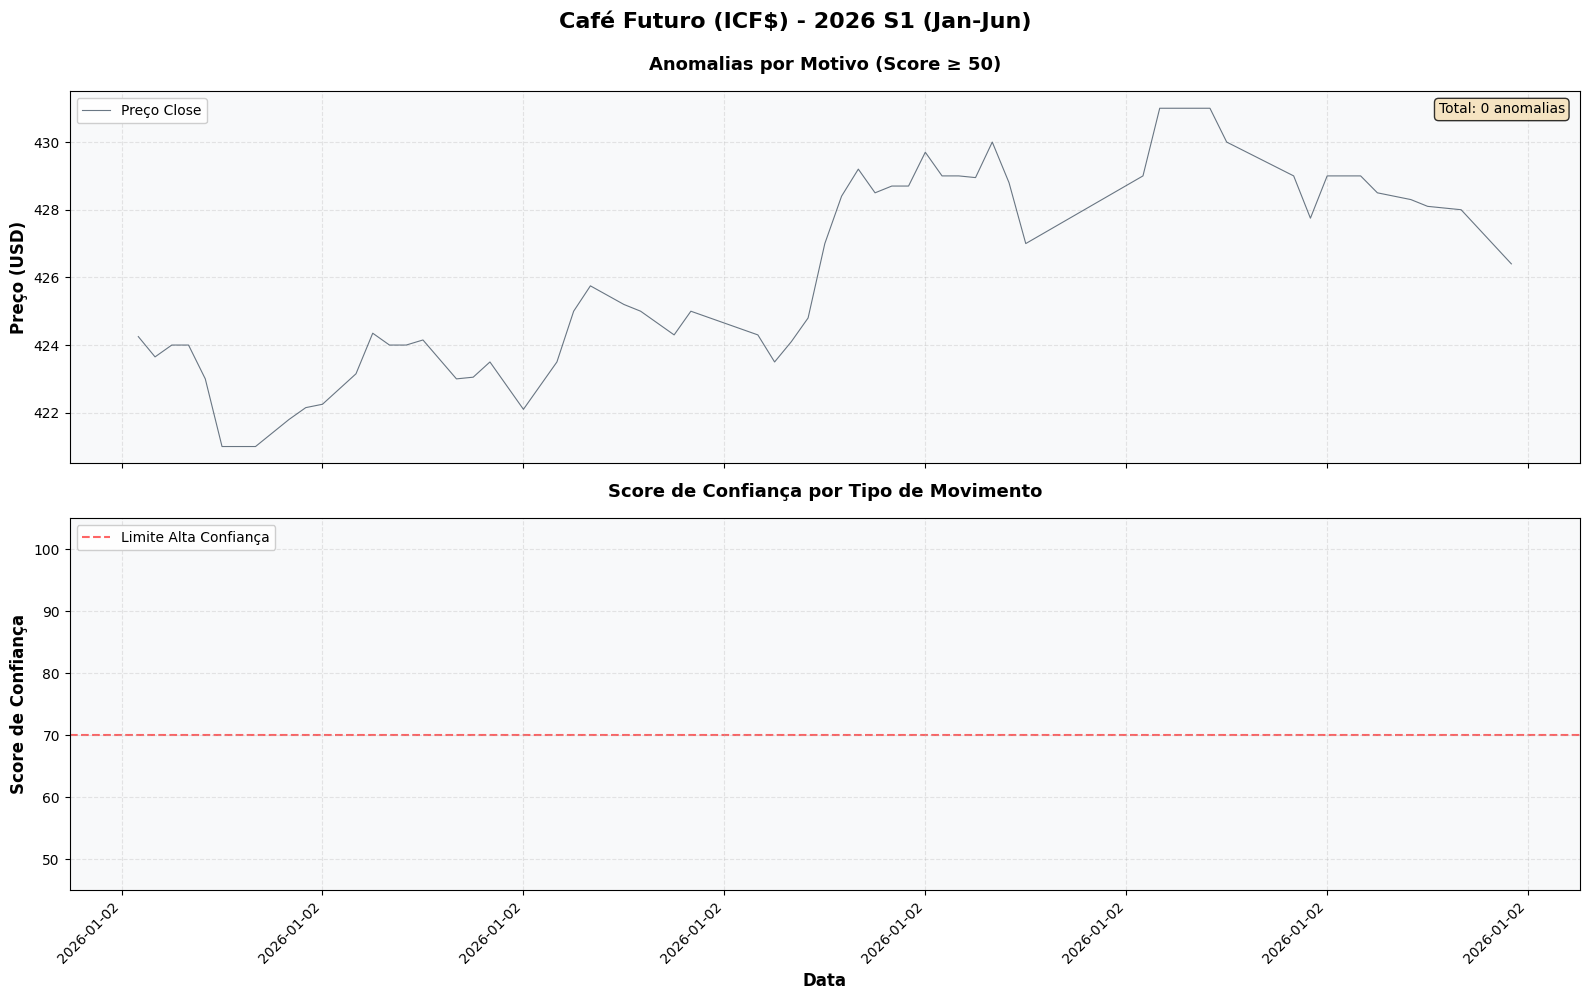

   ⚠️  S2: Sem dados de preço, pulando...

📊 ESTATÍSTICAS GERAIS

🎨 Total de gráficos gerados: 11

📈 Anomalias por Ano-Semestre:
   2021-S1: 78 anomalias
   2021-S2: 49 anomalias
   2022-S1: 41 anomalias
   2022-S2: 41 anomalias
   2023-S1: 44 anomalias
   2023-S2: 62 anomalias
   2024-S1: 55 anomalias
   2024-S2: 55 anomalias
   2025-S1: 66 anomalias
   2025-S2: 45 anomalias

🎯 Distribuição Global por Tipo:
   Alta    :  225 ( 42.0%)
   Baixa   :  270 ( 50.4%)
   Neutro  :   41 (  7.6%)

🔥 Top 5 Maiores Scores (Global):
               Time  Retorno_Pct Tipo_Movimento         Motivo  Score_Confianca
2025-10-01 12:10:00        -0.60          Baixa Amplitude Alta              100
2025-10-07 10:00:00        -0.92          Baixa Amplitude Alta              100
2021-03-30 10:55:00        -0.63          Baixa Amplitude Alta              100
2025-10-08 09:50:00         0.62           Alta Amplitude Alta              100
2025-07-08 10:35:00        -0.91          Baixa Amplitude Alta           

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Visualizador de Anomalias - Café Futuro (ICF$)
Plota gráficos separados por SEMESTRE
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# ==================== CONFIGURAÇÕES ====================
CSV_DADOS = 'M5_ICF$.csv'  # Dados originais
CSV_ANOMALIAS = 'possiveis_noticias_cafe_v2.csv'  # Saída do detector v2

# Filtros
SCORE_MIN = 50  # Mostrar só anomalias com score >= 50
ANOS = None  # None = todos, ou lista [2024, 2025]

print("="*70)
print("📊 VISUALIZADOR DE ANOMALIAS - POR SEMESTRE")
print("="*70)

print("\n📂 Carregando dados...")

# Carrega dados originais
df_preco = pd.read_csv(CSV_DADOS, sep='\t', parse_dates=['Time'])
print(f"✅ Preços: {len(df_preco):,} registros")

# Carrega anomalias
df_anomalias = pd.read_csv(CSV_ANOMALIAS, sep=';', parse_dates=['Time'])
print(f"✅ Anomalias: {len(df_anomalias):,} registros")

# Adiciona semestre
df_preco['Ano'] = df_preco['Time'].dt.year
df_preco['Semestre'] = df_preco['Time'].dt.quarter.apply(lambda q: 1 if q <= 2 else 2)
df_preco['Ano_Semestre'] = df_preco['Ano'].astype(str) + '-S' + df_preco['Semestre'].astype(str)

df_anomalias['Ano'] = df_anomalias['Time'].dt.year
df_anomalias['Semestre'] = df_anomalias['Time'].dt.quarter.apply(lambda q: 1 if q <= 2 else 2)
df_anomalias['Ano_Semestre'] = df_anomalias['Ano'].astype(str) + '-S' + df_anomalias['Semestre'].astype(str)

# Filtra por score
df_anomalias = df_anomalias[df_anomalias['Score_Confianca'] >= SCORE_MIN]
print(f"✅ Anomalias filtradas (score >= {SCORE_MIN}): {len(df_anomalias)}")

# Filtra por anos se especificado
if ANOS:
    df_preco = df_preco[df_preco['Ano'].isin(ANOS)]
    df_anomalias = df_anomalias[df_anomalias['Ano'].isin(ANOS)]
    print(f"✅ Filtrando anos: {ANOS}")

# ==================== CLASSIFICA MOTIVO DA ANOMALIA ====================
def classificar_motivo(row):
    """Identifica qual critério foi mais forte"""
    # Verifica se existe a coluna 'Criterio_Principal' (v2)
    if 'Criterio_Principal' in row.index:
        return row['Criterio_Principal']
    
    # Fallback para v1 (calcula manualmente)
    scores = {
        'Z-Score Alto': abs(row['Z_Score']) / 2.5 if pd.notna(row['Z_Score']) else 0,
        'Amplitude Alta': row['Amplitude_Relativa'] / 2.0 if pd.notna(row['Amplitude_Relativa']) else 0,
        'Volume Alto': row['Volume_Relativo'] / 3.0 if pd.notna(row['Volume_Relativo']) else 0,
    }
    return max(scores, key=scores.get)

df_anomalias['Motivo'] = df_anomalias.apply(classificar_motivo, axis=1)

# ==================== CORES ====================
cores_motivo = {
    'Z-Score Alto': '#E74C3C',      # Vermelho
    'Amplitude Alta': '#F39C12',    # Laranja
    'Volume Alto': '#3498DB',       # Azul
}

cores_tipo = {
    'Alta': '#27AE60',   # Verde
    'Baixa': '#E74C3C',  # Vermelho
    'Neutro': '#95A5A6', # Cinza
}

# ==================== FUNÇÃO DE PLOTAGEM ====================
def plotar_semestre(ano, semestre, df_preco_sem, df_anom_sem):
    """Plota gráfico para um semestre específico"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # Título da figura
    periodo_nome = f"S1 (Jan-Jun)" if semestre == 1 else "S2 (Jul-Dez)"
    fig.suptitle(f'Café Futuro (ICF$) - {ano} {periodo_nome}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # ==================== SUBPLOT 1: Preço + Anomalias ====================
    ax1.plot(df_preco_sem['Time'], df_preco_sem['Close'], 
             color='#2C3E50', linewidth=0.8, alpha=0.7, label='Preço Close')
    
    # Marca anomalias por motivo
    for motivo, cor in cores_motivo.items():
        df_temp = df_anom_sem[df_anom_sem['Motivo'] == motivo]
        if len(df_temp) > 0:
            ax1.scatter(df_temp['Time'], df_temp['Close'], 
                       color=cor, s=100, alpha=0.8, 
                       edgecolors='black', linewidths=1.5,
                       label=f'{motivo} ({len(df_temp)})', zorder=5)
    
    ax1.set_ylabel('Preço (USD)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Anomalias por Motivo (Score ≥ {SCORE_MIN})', 
                 fontsize=13, fontweight='bold', pad=15)
    ax1.legend(loc='upper left', framealpha=0.95, fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_facecolor('#F8F9FA')
    
    # Estatísticas no gráfico
    stats_text = f"Total: {len(df_anom_sem)} anomalias"
    ax1.text(0.99, 0.97, stats_text, transform=ax1.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ==================== SUBPLOT 2: Score de Confiança ====================
    for tipo, cor in cores_tipo.items():
        df_temp = df_anom_sem[df_anom_sem['Tipo_Movimento'] == tipo]
        if len(df_temp) > 0:
            # Tamanho proporcional ao número de critérios (se disponível)
            if 'Num_Criterios' in df_temp.columns:
                sizes = df_temp['Num_Criterios'] * 30  # 1→30, 2→60, 3→90
            else:
                sizes = 60
            
            ax2.scatter(df_temp['Time'], df_temp['Score_Confianca'],
                       color=cor, s=sizes, alpha=0.7,
                       edgecolors='black', linewidths=0.5,
                       label=f'{tipo} ({len(df_temp)})')
    
    ax2.axhline(y=70, color='red', linestyle='--', linewidth=1.5, alpha=0.6, 
                label='Limite Alta Confiança', zorder=1)
    ax2.set_ylabel('Score de Confiança', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Data', fontsize=12, fontweight='bold')
    ax2.set_title('Score de Confiança por Tipo de Movimento', 
                 fontsize=13, fontweight='bold', pad=15)
    ax2.legend(loc='upper left', framealpha=0.95, fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim(SCORE_MIN - 5, 105)
    ax2.set_facecolor('#F8F9FA')
    
    # Estatísticas de tipos
    stats_tipos = []
    for tipo in ['Alta', 'Baixa', 'Neutro']:
        count = len(df_anom_sem[df_anom_sem['Tipo_Movimento'] == tipo])
        if count > 0:
            stats_tipos.append(f"{tipo}: {count}")
    
    stats_text2 = " | ".join(stats_tipos)
    ax2.text(0.99, 0.03, stats_text2, transform=ax2.transAxes,
            fontsize=9, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    # Formata eixo X
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    
    # Salva figura
    filename = f'anomalias_{ano}_S{semestre}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"   💾 Salvo: {filename}")
    
    plt.show()
    plt.close()

# ==================== PLOTAGEM POR SEMESTRE ====================

anos_unicos = sorted(df_preco['Ano'].unique())
print(f"\n📅 Anos encontrados: {anos_unicos}")
print(f"🎨 Gerando gráficos por semestre...")
print(f"   (Cada ano terá 2 gráficos: S1 e S2)")

total_graficos = 0

for ano in anos_unicos:
    print(f"\n📊 Processando ano {ano}...")
    
    for semestre in [1, 2]:
        # Filtra dados do semestre
        df_preco_sem = df_preco[
            (df_preco['Ano'] == ano) & 
            (df_preco['Semestre'] == semestre)
        ]
        
        df_anom_sem = df_anomalias[
            (df_anomalias['Ano'] == ano) & 
            (df_anomalias['Semestre'] == semestre)
        ]
        
        if len(df_preco_sem) == 0:
            print(f"   ⚠️  S{semestre}: Sem dados de preço, pulando...")
            continue
        
        # Plota
        periodo_nome = "Jan-Jun" if semestre == 1 else "Jul-Dez"
        print(f"   📈 S{semestre} ({periodo_nome}): {len(df_anom_sem)} anomalias")
        
        plotar_semestre(ano, semestre, df_preco_sem, df_anom_sem)
        total_graficos += 1

# ==================== ESTATÍSTICAS GLOBAIS ====================
print("\n" + "="*70)
print("📊 ESTATÍSTICAS GERAIS")
print("="*70)

print(f"\n🎨 Total de gráficos gerados: {total_graficos}")

print(f"\n📈 Anomalias por Ano-Semestre:")
distribuicao = df_anomalias['Ano_Semestre'].value_counts().sort_index()
for periodo, count in distribuicao.items():
    print(f"   {periodo}: {count} anomalias")

print(f"\n🎯 Distribuição Global por Tipo:")
for tipo in ['Alta', 'Baixa', 'Neutro']:
    count = len(df_anomalias[df_anomalias['Tipo_Movimento'] == tipo])
    pct = count / len(df_anomalias) * 100 if len(df_anomalias) > 0 else 0
    print(f"   {tipo:8s}: {count:4d} ({pct:5.1f}%)")

print(f"\n🔥 Top 5 Maiores Scores (Global):")
top5 = df_anomalias.nlargest(5, 'Score_Confianca')[
    ['Time', 'Retorno_Pct', 'Tipo_Movimento', 'Motivo', 'Score_Confianca']
]
print(top5.to_string(index=False))

if 'Num_Criterios' in df_anomalias.columns:
    print(f"\n🔢 Distribuição por Número de Critérios:")
    print(df_anomalias['Num_Criterios'].value_counts().sort_index())

print("\n" + "="*70)
print("✅ VISUALIZAÇÃO CONCLUÍDA!")
print(f"   Total de imagens geradas: {total_graficos}")
print(f"   Formato: PNG (anomalias_AAAA_SN.png)")
print("="*70)